In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from datetime import datetime
from sklearn.preprocessing import Normalizer

In [2]:
# Function for converting series data to a supervised data of format, t-1, t, t+1
## Basically feeding in the (t-1)th data to predict the t data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [3]:
def break_timestamp(dataset):
    temp_time = [datetime.strptime(d, "%Y-%m-%d %H:%M:%S.%f") for d in dataset["timestamp"]]
    dataset["hours"] = [dh.hour for dh in temp_time]
    dataset["minutes"] = [dm.minute for dm in temp_time]
    dataset["seconds"] = [ds.second for ds in temp_time]
        
    return dataset

In [9]:
col_arr = ["timestamp", "time_since_last_recording", "ping_timestamp", "time_since_last_ping", "ping_success","ping_time"]
# load dataset
dataset = read_csv('../parse_tactics/normalized_tva_server_1_tactic_1_train.csv')
dataset = break_timestamp(dataset)
dataset = dataset.drop(columns=col_arr)#["ID"])
dataset = dataset[["hours","minutes","seconds","latency","cost","reliability"]]
norm_scaler = Normalizer().fit(dataset.iloc[:,0:3])
dataset.loc[:,0:3] = norm_scaler.transform(dataset.iloc[:,0:3])
values = dataset


#dataset= dataset.drop(columns=["ID"])
#values = dataset.values
#print(dataset.head(5))
## Load Validation
validation = read_csv('../parse_tactics/normalized_tva_server_1_tactic_1_test.csv')
validation = break_timestamp(validation)
validation = validation.drop(columns=col_arr)#["ID"])
validation = validation[["hours","minutes","seconds","latency","cost","reliability"]]
validation.loc[:,0:3] = norm_scaler.transform(validation.iloc[:,0:3])
#validation= validation.drop(columns=["ID"])
values_validation = validation#.values


In [10]:
## Calling the function to do the preprocessing the data and removing unwanted columns


# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed_validation = series_to_supervised(values_validation, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8]], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[[6,7,8]], axis=1, inplace=True)
print(reframed.head(1))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var4(t)  \
1   0.272917   0.579948   0.767578   0.015102   0.193359        1.0  0.015117   

    var5(t)  var6(t)  
1  0.310547        1  


In [11]:
## Splitting the data into training and validation sets


train = reframed.values
test = reframed_validation.values
# split into input and outputs
train_X, train_y = train[:, :-3], train[:,-3:]
test_X, test_y = test[:, :-3], test[:,-3:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(12156, 1, 6) (12156, 3) (2604, 1, 6) (2604, 3)


Epoch 1/20
169/169 [==============================] - 5s 21ms/step - loss: 0.0654 - val_loss: 7.0492e-04
Epoch 2/20
169/169 [==============================] - 3s 19ms/step - loss: 5.3281e-04 - val_loss: 5.4294e-04
Epoch 3/20
169/169 [==============================] - 3s 19ms/step - loss: 4.2062e-04 - val_loss: 3.4302e-04
Epoch 4/20
169/169 [==============================] - 3s 20ms/step - loss: 2.9276e-04 - val_loss: 2.0158e-04
Epoch 5/20
169/169 [==============================] - 3s 19ms/step - loss: 1.9656e-04 - val_loss: 1.4140e-04
Epoch 6/20
169/169 [==============================] - 3s 19ms/step - loss: 1.3710e-04 - val_loss: 1.6293e-04
Epoch 7/20
169/169 [==============================] - 3s 19ms/step - loss: 1.1226e-04 - val_loss: 1.4590e-04
Epoch 8/20
169/169 [==============================] - 3s 20ms/step - loss: 9.2265e-05 - val_loss: 1.0981e-04
Epoch 9/20
169/169 [==============================] - 3s 19ms/step - loss: 7.6563e-05 - val_loss: 1.0004e-04
Epoch 10/20
169/169 [==

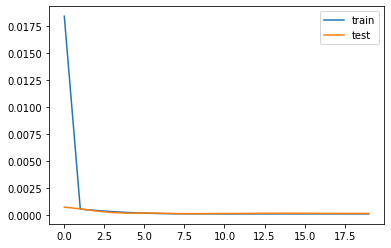

In [12]:
# design LSTM network  has 1000 hidden layers , used adam optimizer and mse loss function
model = Sequential()
model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [14]:
### Doing the same process for testing dataset
test_dataset = read_csv('../parse_tactics/normalized_tva_server_1_tactic_1_validation.csv')
test_dataset = break_timestamp(test_dataset)
test_dataset = test_dataset.drop(columns=col_arr)#["ID"])
test_dataset = test_dataset[["hours","minutes","seconds","latency","cost","reliability"]]
test_dataset.loc[:,0:3] = norm_scaler.transform(test_dataset.iloc[:,0:3])
test_values = test_dataset#.values

#test_dataset = read_csv('normalized_tva_server_1_tactic_1_validation.csv')
#test_dataset= test_dataset.drop(columns=["ID"])
#test_values = test_dataset.values
reframed_test = series_to_supervised(test_values, 1, 1)
reframed_test.drop(reframed_test.columns[[6,7,8]], axis=1, inplace=True)
testset = reframed_test.values
testset_X, testset_y = testset[:, :-3], testset[:,-3:]
testdataReshaped = testset_X.reshape((testset_X.shape[0], 1, testset_X.shape[1]))
print(testset_X.shape, testset_X.shape)

(2605, 6) (2605, 6)


In [15]:
## Feeding the test dataset for predictions
import pandas as pd

yhat = model.predict(testdataReshaped)

print(yhat)
dataset = pd.DataFrame({'predicted_Latency': yhat[:, 0], 'predicted_Cost': yhat[:, 1],
                       'predicted_Reliability': yhat[:, 2]})
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] >0.5] = 1
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] <0.5] = 0

[[0.01552295 0.18692465 0.996784  ]
 [0.01541345 0.18760423 0.996382  ]
 [0.01535036 0.18749322 0.9952749 ]
 ...
 [0.01590683 0.18771446 1.0037286 ]
 [0.01583021 0.18714131 1.001384  ]
 [0.016134   0.18596283 1.0024649 ]]


In [16]:
frames = [test_dataset, dataset]
result = pd.concat(frames,axis =1)

In [17]:
import numpy as np
result.head(10)
result.to_csv('../Prediction_Files/predictions_LSTM_Server_1_Tactic_1.csv', sep=',', index=0)

In [18]:
print(testset_y)

[[0.0149483  0.16796875 1.        ]
 [0.01529248 0.1640625  1.        ]
 [0.0162831  0.16992187 1.        ]
 ...
 [0.01635488 0.1796875  1.        ]
 [0.01666088 0.17382812 1.        ]
 [0.01505033 0.16601562 1.        ]]


In [19]:
## Finding the root mean squared error of the model
import numpy as np

rmse = np.sqrt(mean_squared_error(yhat, testset_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.046
